<a href="https://colab.research.google.com/github/smahasr/Text-Based-Risk-Preidiction/blob/main/Text_Based_Risk_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data preprocessing

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString
from pyspark.ml import Pipeline

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Load the data
data = spark.read.csv("/content/drive/MyDrive/project /Patients_data (1).csv", header=True, inferSchema=True)


In [ ]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="Symptoms", outputCol="tokenized_Symptoms")
data = tokenizer.transform(data)


In [ ]:
# Define stop words
stop_words = StopWordsRemover.loadDefaultStopWords("english")

# Tokenize the text columns
tokenizer = Tokenizer(inputCol="Symptoms", outputCol="tokenized_Symptoms0")
data = tokenizer.transform(data)
tokenizer = Tokenizer(inputCol="Medication", outputCol="tokenized_Medication")
data = tokenizer.transform(data)
tokenizer = Tokenizer(inputCol="Risk Factors", outputCol="tokenized_RiskFactors")
data = tokenizer.transform(data)

In [ ]:
# Remove stop words
remover = StopWordsRemover(inputCol="tokenized_Symptoms", outputCol="filtered_tokenizedSymptoms", stopWords=stop_words)
data = remover.transform(data)
remover.setInputCol("tokenized_Medication").setOutputCol("filtered_tokenizedMedication")
data = remover.transform(data)
remover.setInputCol("tokenized_RiskFactors").setOutputCol("filtered_tokenizedRiskFactors")
data = remover.transform(data)

In [ ]:
# Generate word embeddings for Symptoms
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_tokenizedSymptoms", outputCol="Embedded_Symptoms")
model = word2vec.fit(data)
data = model.transform(data)

# Generate word embeddings for Medication
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_tokenizedMedication", outputCol="Embedded_Medication")
model = word2vec.fit(data)
data = model.transform(data)

# Generate word embeddings for Risk Factors
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_tokenizedRiskFactors", outputCol="Embedded_RiskFactors")
model = word2vec.fit(data)
data = model.transform(data)

In [ ]:
# Now you can use the VectorAssembler
assembler = VectorAssembler(inputCols=["Embedded_Symptoms", "Embedded_Medication", "Embedded_RiskFactors"], outputCol="features")
data = assembler.transform(data)

# Splitting the Data

In [ ]:
# Split the dataset into training and test sets
(training_data, test_data) = data.randomSplit([0.75, 0.25], seed=1234)

In [ ]:
# Define the RandomForest model
rf = RandomForestClassifier(labelCol="Risk Level", featuresCol="features", numTrees=10)

In [ ]:
from pyspark.ml.feature import Bucketizer, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
import pandas as pd
import joblib


# Define the splits for the Bucketizer
splits = [-float("inf"), 0.5, 1.5, float("inf")]

# Initialize the Bucketizer
bucketizer = Bucketizer(splits=splits, inputCol="Risk Level", outputCol="bucketedLabel12")

# Transform the data
data = bucketizer.transform(data)


# Initialize StringIndexer for Risk
indexer = StringIndexer(inputCol="bucketedLabel12", outputCol="label1")
data = indexer.fit(data).transform(data)



In [ ]:

# Split the dataset into training and test sets
(training_data, test_data) = data.randomSplit([0.75, 0.25], seed=1234)

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="label1", featuresCol="features", numTrees=10)

# Fit the model
model = rf.fit(training_data)



In [ ]:
# Save the model to a path
model.write().overwrite().save("/content/drive/MyDrive /rf_model_path")

In [ ]:
model


RandomForestClassificationModel: uid=RandomForestClassifier_ad13cace9cfd, numTrees=10, numClasses=2, numFeatures=300

In [ ]:
# Make predictions
predictions = model.transform(test_data)

In [ ]:

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label1", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Precision, Recall, F1 Score
evaluator = MulticlassClassificationEvaluator(labelCol="label1", predictionCol="prediction")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Weighted Precision = {precision}")
print(f"Weighted Recall = {recall}")
print(f"F1 Score = {f1}")


Test set accuracy = 0.9845814977973568
Weighted Precision = 0.984187060690132
Weighted Recall = 0.9845814977973568
F1 Score = 0.984216743148615


In [ ]:

# Show the DataFrame
predictions.select("Patient Name", "label1", "Risk Level").show()


+------------------+------+----------+
|      Patient Name|label1|Risk Level|
+------------------+------+----------+
|    Aaron Mcintosh|   0.0|       1.0|
|    Aaron Williams|   0.0|       1.0|
|      Alan Wallace|   0.0|       1.0|
|  Alexander Nelson|   0.0|       1.0|
|Alexander Reynolds|   0.0|       1.0|
|    Alexander Ross|   0.0|       1.0|
|   Alexandra Scott|   0.0|       1.0|
|   Alexandria Moss|   1.0|       0.4|
|  Alexis Schroeder|   0.0|       1.0|
|       Alexis Wolf|   0.0|       1.0|
|       Allen Cross|   0.0|       1.0|
|      Amanda James|   0.0|       1.0|
|     Amanda Murray|   0.0|       0.5|
|      Amber Martin|   0.0|       1.0|
|      Amber Willis|   0.0|       1.0|
|      Amy Anderson|   0.0|       1.0|
|         Amy Bates|   0.0|       1.0|
|          Amy King|   0.0|       1.0|
|        Amy Porter|   0.0|       0.5|
|          Ana Lowe|   0.0|       1.0|
+------------------+------+----------+
only showing top 20 rows



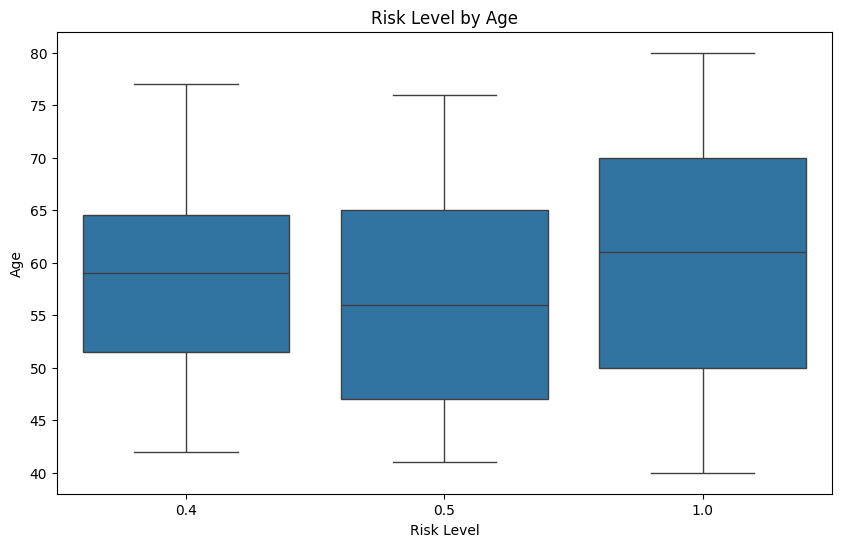

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.toPandas()

# Plot risk level by age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Risk Level', y='Age', data=predictions_pd)
plt.title('Risk Level by Age')
plt.show()



OUTOF SAMPLE PREDICTION:

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("Predictions").getOrCreate()

# Load your new data
new_data = spark.read.format("csv").option("header", "true").load('/content/drive/MyDrive/project /Outofsampleprediction (1).csv')

In [ ]:
# Tokenize the text columns
tokenizer = Tokenizer(inputCol="Symptoms", outputCol="tokenized_Symptoms")
new_data = tokenizer.transform(new_data)
tokenizer = Tokenizer(inputCol="Medication", outputCol="tokenized_Medication")
new_data = tokenizer.transform(new_data)
tokenizer = Tokenizer(inputCol="Risk Factors", outputCol="tokenized_RiskFactors")
new_data = tokenizer.transform(new_data)

In [ ]:
# Remove stop words
stop_words = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol="tokenized_Symptoms", outputCol="filtered_tokenizedSymptoms", stopWords=stop_words)
new_data = remover.transform(new_data)
remover.setInputCol("tokenized_Medication").setOutputCol("filtered_tokenizedMedication")
new_data = remover.transform(new_data)
remover.setInputCol("tokenized_RiskFactors").setOutputCol("filtered_tokenizedRiskFactors")
new_data = remover.transform(new_data)

In [ ]:
# Generate word embeddings
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_tokenizedSymptoms", outputCol="Embedded_Symptoms")
model = word2vec.fit(new_data)
new_data = model.transform(new_data)
word2vec.setInputCol("filtered_tokenizedMedication").setOutputCol("Embedded_Medication")
model = word2vec.fit(new_data)
new_data = model.transform(new_data)
word2vec.setInputCol("filtered_tokenizedRiskFactors").setOutputCol("Embedded_RiskFactors")
model = word2vec.fit(new_data)
new_data = model.transform(new_data)

In [ ]:

# Assemble the features
assembler = VectorAssembler(inputCols=["Embedded_Symptoms", "Embedded_Medication", "Embedded_RiskFactors"], outputCol="features")
new_data = assembler.transform(new_data)

In [ ]:

# Load your trained RandomForestClassifier model
rf_model = RandomForestClassificationModel.load('/content/drive/MyDrive/rf_model_path')

In [ ]:
# Use the model to make predictions on the new data
new_predictions = rf_model.transform(new_data)

In [ ]:
# Show the predictions
new_predictions.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



In [ ]:
# Create a StringIndexer
indexer = StringIndexer(inputCol="prediction", outputCol="Risk Level Index")

In [ ]:
# Fit the indexer to the data
indexer_model = indexer.fit(new_predictions)


In [ ]:
# Create a new DataFrame with numeric labels
new_predictions = indexer_model.transform(new_predictions)

In [ ]:
# Now use the 'Risk Level Index' as your labelCol
evaluator = MulticlassClassificationEvaluator(
    labelCol="Risk Level Index",
    predictionCol="prediction",
    metricName="accuracy")

accuracy = evaluator.evaluate(new_predictions)
print("Accuracy = %g" % accuracy)

Accuracy = 1


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'Risk Level Index' is your column with the true labels
label_col = "Risk Level Index"

# Create evaluators

precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")

# Compute metrics

test_precision = precision_evaluator.evaluate(new_predictions)
test_recall = recall_evaluator.evaluate(new_predictions)
test_f1 = f1_evaluator.evaluate(new_predictions)

# Print metrics
print("Test set metrics:")

print("Weighted Precision = %g" % test_precision)
print("Weighted Recall = %g" % test_recall)
print("F1 Score = %g" % test_f1)


Test set metrics:
Weighted Precision = 1
Weighted Recall = 1
F1 Score = 1


# Prediction with lstm:

In [ ]:
!pip install --upgrade pyspark


In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws

# Initialize SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the data
data = spark.read.csv("/content/drive/MyDrive/project /Patients_data (1).csv", header=True, inferSchema=True)

# Combine text columns
data = data.withColumn("combined_text", concat_ws(" ", data["Symptoms"], data["Medication"], data["Risk Factors"]))

# Text pre-processing
tokenizer = Tokenizer(inputCol="combined_text", outputCol="tokenized_text")
stop_words = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol="tokenized_text", outputCol="filtered_text", stopWords=stop_words)
data = tokenizer.transform(data)
data = remover.transform(data)

# Generate word embeddings
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_text", outputCol="features")
model = word2vec.fit(data)
data = model.transform(data)

# Label Encoding
labelIndexer = StringIndexer(inputCol="Risk Level", outputCol="labelIndexed")
data = labelIndexer.fit(data).transform(data)

# Split the dataset into training and test sets
(training_data, test_data) = data.randomSplit([0.75, 0.25], seed=1234)

# Define the MultilayerPerceptron model
layers = [100, 50, len(data.select("Risk Level").distinct().collect())]  # Output layer size matches number of risk categories
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, labelCol="labelIndexed")

# Train the MLP model
mlp_model = mlp.fit(training_data)

# Make predictions on test data
predictions = mlp_model.transform(test_data)


# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")


Test set accuracy = 0.9515418502202643


In [ ]:
!ls -l "/content/drive/MyDrive/rf_model_path"


total 12
drwx------ 2 root root 4096 May 20 17:11 data
drwx------ 2 root root 4096 May 20 17:11 metadata
drwx------ 2 root root 4096 May 20 17:11 treesMetadata
